# SARIMAX for the prediction of energy consumption data over 48 hours

In [ ]:
#Install all required packages with 'conda install NAME' or with pip install NAME'
# pandas
# numpy
# matplotlib
# scikit-learn
# statsmodels
# pmdarima
# psutil

In [2]:
#Import all required libraries
import sys  # Provides access to some variables used or maintained by the interpreter
import pandas as pd # Library for data manipulation and analysis, ideal for working with structured data like tables
import numpy as np # For scientific computing, support for large, multi-dimensional arrays and matrices
import matplotlib.pyplot as plt # For creating static, interactive, and animated visualizations
import matplotlib.dates as mdates # Provides matplotlib with date-specific plotting tools
from sklearn.preprocessing import MinMaxScaler # For scaling and normalizing features, often useful in data preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error # For calculating common statistical error metrics
import pmdarima as pm # For ARIMA modeling in Python, which simplifies the process of building ARIMA models
from pmdarima.model_selection import train_test_split # Provides model selection capabilities like train/test splits
import statsmodels.api as sm # Provides many statistical models and functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # For plotting autocorrelation and partial autocorrelation charts
import psutil # For accessing system details and process utilities, helpful for monitoring system performance
from pathlib import Path  # Used for filesystem path manipulation in an object-oriented way

In [1]:
#To display the current environment
print(sys.executable)

/home/sarah/anaconda3/envs/BT2024SARIMAModel/bin/python


In [3]:
# Step 1 - Reading Data

## dfClimaAll: Data from 2021-2023
## dfEnergyAll: All data from the transformer station from 2021-2023

# Load data for 2021
dfClima21 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2021TimeWeather.xlsx')

# Load data for 2022
dfClima22 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2022TimeWeather.xlsx')

# Load data for 2023
dfClima23 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2023TimeWeather.xlsx')

# Merge the DataFrames
#Only DF23
dfClimaAll = dfClima23.copy()
#All DFs:
#dfClimaAll = pd.concat([dfClima21, dfClima22, dfClima23])

# Check the resulting DataFrame
print("First and last rows from dfClimaAll:")
print(dfClimaAll.head())
print(dfClimaAll.tail())

# Check for missing values in each column
## .isnull(): Returns DF where values with NaN are replaced by True & values without NaN are replaced by False
## sum(): Sums up the number of True values
print("Number of missing values per column:")
print(dfClimaAll.isnull().sum())

# Convert 'Timestamp' into a Datetime object and set it as index, if not already set
if 'TimestampWeather' in dfClimaAll.columns:
    ## pd.to_datetime: Converts values into Datetime objects —> Pandas can then treat these as timestamps
    dfClimaAll['TimestampWeather'] = pd.to_datetime(dfClimaAll['TimestampWeather'])
    ## set_index: Sets index for the Timestamp column to facilitate access to data based on time points
    dfClimaAll = dfClimaAll.set_index('TimestampWeather')

# Number of rows in dfClimaAll
print("Number of rows in dfClimaAll:", dfClimaAll.shape[0])

Erste und letzte Zeilen aus dfClimaAll:
   dy  Globalstrahlung_15Min  Sonnenhöhe  ExtraterrestrischeStrahlung  \
0   1                      0       -65.0                            0   
1   1                      0       -65.0                            0   
2   1                      0       -65.4                            0   
3   1                      0       -65.5                            0   
4   1                      0       -65.2                            0   

   StundenwertStrahlung  Diffusstrahlung  StrahlungGeneigteFläche  \
0                     0                0                        0   
1                     0                0                        0   
2                     0                0                        0   
3                     0                0                        0   
4                     0                0                        0   

   DiffusstrahlungGeneigteFläche  Direktnormalstrahlung  Lufttemperatur  \
0                              

In [4]:
# Step 1 - Reading Data

## dfClimaAll: Data from 2021-2023
## dfEnergyAll: All data from the transformer station from 2021-2023

# Path to the directory containing the Excel files
directory_path = Path('/home/sarah/Documents/BT2024/2023')

# Create a list of all Excel files in the directory
file_paths = list(directory_path.glob('*.xlsx'))

# List to store the individual DataFrames
dfs = []

# Loop over all file paths
for file_path in file_paths:
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Convert the 'Timestamp' column into a datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Convert the 'Lastgang' column into a numeric data type, treating errors as NaN
    df['Lastgang'] = pd.to_numeric(df['Lastgang'], errors='coerce')
    
    # Sort the DataFrame by the 'Timestamp'
    df = df.sort_values(by='Timestamp')
    
    # Perform linear interpolation for the 'Lastgang' on the individual DataFrame
    df['Lastgang'] = df['Lastgang'].interpolate(method='linear')
    
    # Add the DataFrame to the list
    dfs.append(df)

# Merge all DataFrames in the list
dfEnergyAll = pd.concat(dfs).set_index('Timestamp')

# Sum the Lastgang values for identical timestamps
dfEnergyAll = dfEnergyAll.groupby('Timestamp').sum()

# Check the resulting DataFrame
print("First and last rows from dfEnergyAll:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

# Display the number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])


Erste und letzte Zeilen aus dfEnergyAll:
                     Lastgang
Timestamp                    
2023-01-01 00:00:00    657.35
2023-01-01 00:15:00    677.68
2023-01-01 00:30:00    644.91
2023-01-01 00:45:00    656.67
2023-01-01 01:00:00    660.77
                     Lastgang
Timestamp                    
2023-12-31 22:45:00    833.17
2023-12-31 23:00:00    767.89
2023-12-31 23:15:00    770.04
2023-12-31 23:30:00    730.45
2023-12-31 23:45:00    744.21
Anzahl der Zeilen in dfEnergyAll: 35036


In [5]:
# Step 2 - Preparing the Data

# Create a complete timestamp index for the years 2023 in 15-minute intervals
all_timestamps = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:45:00', freq='15T')

# Convert this into a DataFrame
df_all_timestamps = pd.DataFrame(all_timestamps, columns=['Timestamp'])
df_all_timestamps = df_all_timestamps.set_index('Timestamp')

# Compare the complete timestamp index with dfEnergyAll
missing_timestamps = df_all_timestamps.index.difference(dfEnergyAll.index)

print("Missing timestamps in dfEnergyAll:")
print(missing_timestamps)


# Missing timestamps
missing_timestamps = pd.DatetimeIndex(['2023-03-26 02:00:00', '2023-03-26 02:15:00',
                                       '2023-03-26 02:30:00', '2023-03-26 02:45:00'])

# Create a DataFrame with the missing timestamps
df_missing = pd.DataFrame(index=missing_timestamps)

# Merge this DataFrame with the original DataFrame
dfEnergyAll = dfEnergyAll.combine_first(df_missing)

# Fill the missing values. Use 'ffill' for forward fill.
dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')

print("Check after adding the missing timestamps:")
print(dfEnergyAll.loc[missing_timestamps])

# Number of rows in dfClima21
# Ensure dfClima21 is already defined before executing this line.
print("Number of rows in dfClima21:", dfClimaAll.shape[0])

# Number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

Fehlende Zeitstempel in dfEnergyAll:
DatetimeIndex(['2023-03-26 02:00:00', '2023-03-26 02:15:00',
               '2023-03-26 02:30:00', '2023-03-26 02:45:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)
Überprüfen nach dem Ergänzen der fehlenden Zeitstempel:
                     Lastgang
2023-03-26 02:00:00    520.34
2023-03-26 02:15:00    520.34
2023-03-26 02:30:00    520.34
2023-03-26 02:45:00    520.34
Anzahl der Zeilen in dfClima21: 35040
Anzahl der Zeilen in dfEnergyAll: 35040


/tmp/ipykernel_1561988/424088960.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')


In [6]:
# Step 2 - Preparing the Data

# To check if the indexes in both DataFrames are set equally
dfClimaAll.index.equals(dfEnergyAll.index)

# Adding the columns from dfClima21 to dfEnergyAll
dfEnergyAll = dfEnergyAll.join(dfClimaAll[['StundenwertStrahlung', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'TheorPVProd', 'Direktnormalstrahlung', 'Schönwetterstrahlung', 'Lufttemperatur']])

# Checking for missing values in each column
print("Number of missing values per column:")
print(dfEnergyAll.isnull().sum())

# Printing the first and last rows from the dataframe
print("First and last rows from dfEnergyAll-Edited:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

Anzahl fehlender Werte pro Spalte:
Lastgang                   0
StundenwertStrahlung       0
Globalstrahlung_15Min      0
StrahlungGeneigteFläche    0
TheorPVProd                0
Direktnormalstrahlung      0
Schönwetterstrahlung       0
Lufttemperatur             0
dtype: int64
Erste Zeilen aus dfEnergyAll-Bearbeitet:
                     Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
2023-01-01 00:00:00    657.35                     0                      0   
2023-01-01 00:15:00    677.68                     0                      0   
2023-01-01 00:30:00    644.91                     0                      0   
2023-01-01 00:45:00    656.67                     0                      0   
2023-01-01 01:00:00    660.77                     0                      0   

                     StrahlungGeneigteFläche  TheorPVProd  \
2023-01-01 00:00:00                        0            0   
2023-01-01 00:15:00                        0            0   
2023-01-01 00:30:00        

In [7]:
# Step 2 - Preparing the Data

# Calculating the moving average for 'Lastgang'
window_size = 96  # This corresponds to 24 hours at 15-minute intervals
dfEnergyAll['Lastgang_Moving_Average'] = dfEnergyAll['Lastgang'].rolling(window=window_size).mean()

# Calculating the first differences for 'Lastgang'
dfEnergyAll['Lastgang_First_Difference'] = dfEnergyAll['Lastgang'].diff()

# Since the first `window_size - 1` values of the moving average will be NaN and the first value of the first difference will be NaN, fill these values.
dfEnergyAll = dfEnergyAll.fillna(method='bfill')

# To check the first few rows to ensure the new features look as expected.
print(dfEnergyAll.head())

                     Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
2023-01-01 00:00:00    657.35                     0                      0   
2023-01-01 00:15:00    677.68                     0                      0   
2023-01-01 00:30:00    644.91                     0                      0   
2023-01-01 00:45:00    656.67                     0                      0   
2023-01-01 01:00:00    660.77                     0                      0   

                     StrahlungGeneigteFläche  TheorPVProd  \
2023-01-01 00:00:00                        0            0   
2023-01-01 00:15:00                        0            0   
2023-01-01 00:30:00                        0            0   
2023-01-01 00:45:00                        0            0   
2023-01-01 01:00:00                        0            0   

                     Direktnormalstrahlung  Schönwetterstrahlung  \
2023-01-01 00:00:00                      0                     0   
2023-01-01 00:15:00         

/tmp/ipykernel_1561988/3400565057.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.fillna(method='bfill')


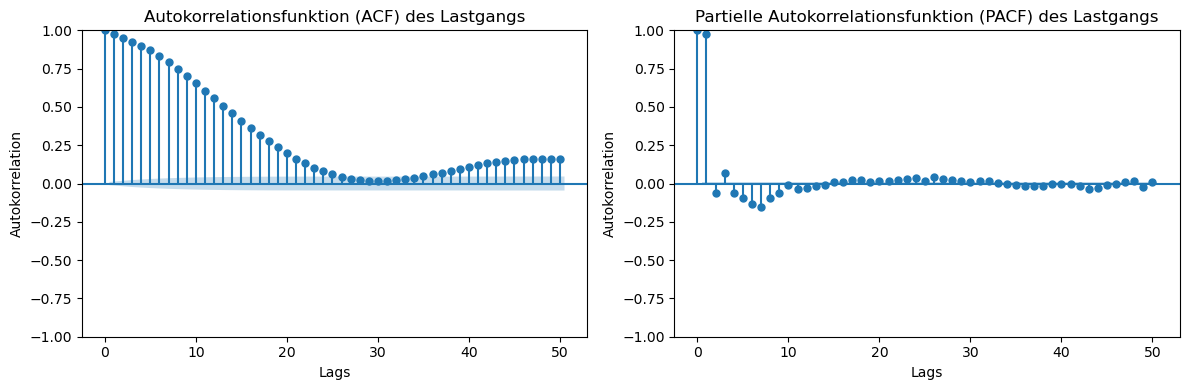

In [8]:
# Step 2 - Preparing the Data

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns, and an optional size specification

# ACF plot in the first subplot
plot_acf(dfEnergyAll['Lastgang'].dropna(), lags=50, ax=ax1)  # Autocorrelation plot for 'Lastgang' with 50 lags
ax1.set_title('Autocorrelation Function (ACF) of Lastgang')  # Set title for the first subplot
ax1.set_xlabel('Lags')  # Set x-label as 'Lags'
ax1.set_ylabel('Autocorrelation')  # Set y-label as 'Autocorrelation'

# PACF plot in the second subplot
plot_pacf(dfEnergyAll['Lastgang'].dropna(), lags=50, ax=ax2)  # Partial autocorrelation plot for 'Lastgang' with 50 lags
ax2.set_title('Partial Autocorrelation Function (PACF) of Lastgang')  # Set title for the second subplot
ax2.set_xlabel('Lags')  # Set x-label as 'Lags'
ax2.set_ylabel('Autocorrelation')  # Set y-label as 'Autocorrelation'

# Adjust spacing between the plots
plt.tight_layout()

# Display the plots
plt.show()

In [9]:
# Step 3 - Data Scaling

# Initialize the scalers
lastgang_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the corresponding columns
dfEnergyAll['Lastgang'] = lastgang_scaler.fit_transform(dfEnergyAll['Lastgang'].values.reshape(-1, 1))
dfEnergyAll[['StundenwertStrahlung', 'Lufttemperatur', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']] = features_scaler.fit_transform(dfEnergyAll[['StundenwertStrahlung', 'Lufttemperatur', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']])

In [ ]:
# Step 3 - Check the scaled values

print(dfEnergyAll.describe())

print("Skalierparameter für Lastgang:", lastgang_scaler.scale_, lastgang_scaler.min_)

In [10]:
# Step 3 - Show GPU Utilization and Memory Usage before Model Training

#def print_gpu_utilization():
    # Retrieve and print GPU utilization and memory stats
 #   GPUs = GPUtil.getGPUs()
  #  for GPU in GPUs:
   #     print(f"GPU: {GPU.name}, GPU RAM Free: {GPU.memoryFree}MB, Used: {GPU.memoryUsed}MB, Utilization: {GPU.load*100}%")

#print("GPU before model training:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
#print_gpu_utilization()

# Function to print CPU utilization
def print_cpu_utilization():
    # Retrieve and print the percentage of CPU utilization
    print(f"CPU Utilization: {psutil.cpu_percent(interval=1)}%")

print("CPU before model training:")
print_cpu_utilization()

def print_memory_usage():
    # Retrieve and print memory statistics
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage: {memory.percent}%")

print("RAM before model training:")
print_memory_usage()


CPU before model training:
CPU Utilization: 98.6%
RAM before model training:
Total memory: 146.88 GB
Available memory: 109.45 GB
Used memory: 35.63 GB
Memory usage: 25.5%


In [ ]:
# Step 4 - Creating the SARIMAX model and generating predictions

# Ensure the index is set as DatetimeIndex and has the correct frequency
dfEnergyAll.index = pd.to_datetime(dfEnergyAll.index)  # Convert the index to datetime type
dfEnergyAll = dfEnergyAll.asfreq('15T')  # Set the frequency of the DataFrame to every 15 minutes

# Split the data into training and testing sets
# Since you want to forecast 48 hours ahead (192 fifteen-minute intervals), take this into account when splitting
train, test = train_test_split(dfEnergyAll, train_size=len(dfEnergyAll)-192)

# Separate the target variable (Lastgang) and the exogenous variables
y_train = train['Lastgang']  # Target variable for training
X_train = train[['StundenwertStrahlung', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'TheorPVProd', 'Direktnormalstrahlung', 'Schönwetterstrahlung', 'Lufttemperatur', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']]  # Exogenous variables for training
# Only 1 external variable: , 'Lufttemperatur'

y_test = test['Lastgang']  # Target variable for testing, used later for evaluation
X_test = test[['StundenwertStrahlung', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'TheorPVProd', 'Direktnormalstrahlung', 'Schönwetterstrahlung', 'Lufttemperatur', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']]  # Exogenous variables for testing, used for predictions
# Only 1 external variable: , 'Lufttemperatur'

# Define and fit the SARIMAX model
# SARIMAX model with ARIMA(1,0,0) and seasonal order (1,0,0,96)
model = sm.tsa.SARIMAX(y_train, exog=X_train, order=(1,0,0), seasonal_order=(1,0,0,96), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Display the model summary
print(results.summary())

# Use the model for predictions
predictions = results.get_forecast(steps=192, exog=X_test).predicted_mean  # Forecasting using the model


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.08057D+00    |proj g|=  1.19631D+03


 This problem is unconstrained.


In [ ]:
# Step 5 - Rescaling, error metrics and visualization

# Rescale predictions and review
predictions_original_scale = lastgang_scaler.inverse_transform(predictions.to_numpy().reshape(-1, 1))  # Rescale the predictions to the original scale
print("After rescaling (first 5 values):", predictions_original_scale[:5])  # Print the first 5 rescaled prediction values

# Rescale actual values and review
y_test_original_scale = lastgang_scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1))  # Rescale the actual values to the original scale
print("Actual values after rescaling (first 5 values):", y_test_original_scale[:5])  # Print the first 5 rescaled actual values

In [ ]:
# Step 5 - Rescaling, error metrics and visualization

# Create a series for SARIMAX forecast results with timestamps
sarimax_forecast_series = pd.Series(predictions, index=y_test.index)  # Initially store predictions in a series with the test set's timestamps

# Create a series for SARIMAX forecast results with timestamps using rescaled predictions
sarimax_forecast_series = pd.Series(predictions_original_scale.ravel(), index=y_test.index)  # Use rescaled predictions for the series

# Calculate error metrics for SARIMAX model predictions
mse = mean_squared_error(y_test_original_scale, sarimax_forecast_series)  # Calculate mean squared error
mae = mean_absolute_error(y_test_original_scale, sarimax_forecast_series)  # Calculate mean absolute error
rmse = np.sqrt(mse)  # Calculate root mean square error
mape = np.mean(np.abs((y_test_original_scale.ravel() - sarimax_forecast_series) / y_test_original_scale.ravel())) * 100  # Calculate mean absolute percentage error

# Output error metrics for SARIMAX model predictions
print(f"Mean Squared Error (MSE) for the last 2 days: {mse}")
print(f"Mean Absolute Error (MAE) for the last 2 days: {mae}")
print(f"Root Mean Square Error (RMSE) for the last 2 days: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE) for the last 2 days: {mape}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test_original_scale, label='Actual Values', color='#3E7A6F')  # Plot actual values
plt.plot(sarimax_forecast_series.index, sarimax_forecast_series, label='Predicted Values', color='#7DFFE7')  # Plot predicted values
plt.legend()
plt.title('Comparison of Actual and Predicted Values: SARIMAX over 48 Hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Format the x-axis labels to show month-day and time
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Set major tick intervals on the x-axis
plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
plt.show()

In [ ]:
# Step 7 - Show GPU Utilization and Memory Usage after Model Training

#print("GPU after model training:", datetime.now().strftime("%Y-%m-%d %H:%M:%S")) # Print GPU utilization after model training
#print_gpu_utilization() # Call function to print GPU utilization

print("CPU after model training:") # Print CPU utilization after model training
print_cpu_utilization() # Call function to print CPU utilization

print("RAM after model training:") # Print RAM usage after model training
print_memory_usage() # Call function to print RAM usage